TensorFlow训练好的模型以tensorflow原生方式保存成protobuf文件后可以用许多方式部署运行。

例如：通过 tensorflow-js 可以用javascrip脚本加载模型并在浏览器中运行模型。

通过 tensorflow-lite 可以在移动和嵌入式设备上加载并运行TensorFlow模型。

通过 tensorflow-serving 可以加载模型后提供网络接口API服务，通过任意编程语言发送网络请求都可以获取模型预测结果。

通过 tensorFlow for Java接口，可以在Java或者spark(scala)中调用tensorflow模型进行预测。

我们主要介绍tensorflow serving部署模型、使用spark(scala)调用tensorflow模型的方法。

〇，tensorflow serving模型部署概述
使用 tensorflow serving 部署模型要完成以下步骤。

(1) 准备protobuf模型文件。

(2) 安装tensorflow serving。

(3) 启动tensorflow serving 服务。

(4) 向API服务发送请求，获取预测结果。

In [ ]:
#一，准备protobuf模型文件
#我们使用tf.keras 训练一个简单的线性回归模型，并保存成protobuf文件。
import tensorflow as tf
from tensorflow.keras import models,layers,optimizers

## 样本数量
n = 800

## 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-1.0]])
b0 = tf.constant(3.0)

Y = X@w0 + b0 + tf.random.normal([n,1],
    mean = 0.0,stddev= 2.0) # @表示矩阵乘法,增加正态扰动

## 建立模型
tf.keras.backend.clear_session()
inputs = layers.Input(shape = (2,),name ="inputs") #设置输入名字为inputs
outputs = layers.Dense(1, name = "outputs")(inputs) #设置输出名字为outputs
linear = models.Model(inputs = inputs,outputs = outputs)
linear.summary()

## 使用fit方法进行训练
linear.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
linear.fit(X,Y,batch_size = 8,epochs = 100)  

tf.print("w = ",linear.layers[1].kernel)
tf.print("b = ",linear.layers[1].bias)

## 将模型保存成pb格式文件
export_path = "./data/linear_model/"
version = "1"       #后续可以通过版本号进行模型版本迭代与管理
linear.save(export_path+version, save_format="tf") 

In [ ]:
#查看保存的模型文件
!ls {export_path+version}

In [ ]:
# 查看模型文件相关信息
!saved_model_cli show --dir {export_path+str(version)} --all

In [ ]:
#二，安装 tensorflow serving
#安装 tensorflow serving 有2种主要方法：通过Docker镜像安装，通过apt安装。

#通过Docker镜像安装是最简单，最直接的方法，推荐采用


# 三，启动 tensorflow serving 服务
"""
!docker run -t --rm -p 8501:8501 \
    -v "/Users/.../data/linear_model/" \
    -e MODEL_NAME=linear_model \
    tensorflow/serving & >server.log 2>&1
"""

# 四，向API服务发送请求
import json,requests

data = json.dumps({"signature_name": "serving_default", "instances": [[1.0, 2.0], [5.0,7.0]]})
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/linear_model:predict', 
        data=data, headers=headers)
predictions = json.loads(json_response.text)["predictions"]
print(predictions)

# spark(scala) --- tensorflow

In [ ]:

spark-scala调用tensorflow模型概述
在spark(scala)中调用tensorflow模型进行预测需要完成以下几个步骤。

（1）准备protobuf模型文件

（2）创建spark(scala)项目，在项目中添加java版本的tensorflow对应的jar包依赖

（3）在spark(scala)项目中driver端加载tensorflow模型调试成功

（4）在spark(scala)项目中通过RDD在executor上加载tensorflow模型调试成功

（5） 在spark(scala)项目中通过DataFrame在executor上加载tensorflow模型调试成功

In [ ]:

#一，准备protobuf模型文件
#我们使用tf.keras 训练一个简单的线性回归模型，并保存成protobuf文件。

import tensorflow as tf
from tensorflow.keras import models,layers,optimizers

## 样本数量
n = 800

## 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-1.0]])
b0 = tf.constant(3.0)

Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动

## 建立模型
tf.keras.backend.clear_session()
inputs = layers.Input(shape = (2,),name ="inputs") #设置输入名字为inputs
outputs = layers.Dense(1, name = "outputs")(inputs) #设置输出名字为outputs
linear = models.Model(inputs = inputs,outputs = outputs)
linear.summary()

## 使用fit方法进行训练
linear.compile(optimizer="rmsprop",loss="mse",metrics=["mae"])
linear.fit(X,Y,batch_size = 8,epochs = 100)  

tf.print("w = ",linear.layers[1].kernel)
tf.print("b = ",linear.layers[1].bias)

## 将模型保存成pb格式文件
export_path = "./data/linear_model/"
version = "1"       #后续可以通过版本号进行模型版本迭代与管理
linear.save(export_path+version, save_format="tf") 

In [ ]:
!ls {export_path+version}

In [ ]:
# 查看模型文件相关信息
!saved_model_cli show --dir {export_path+str(version)} --all

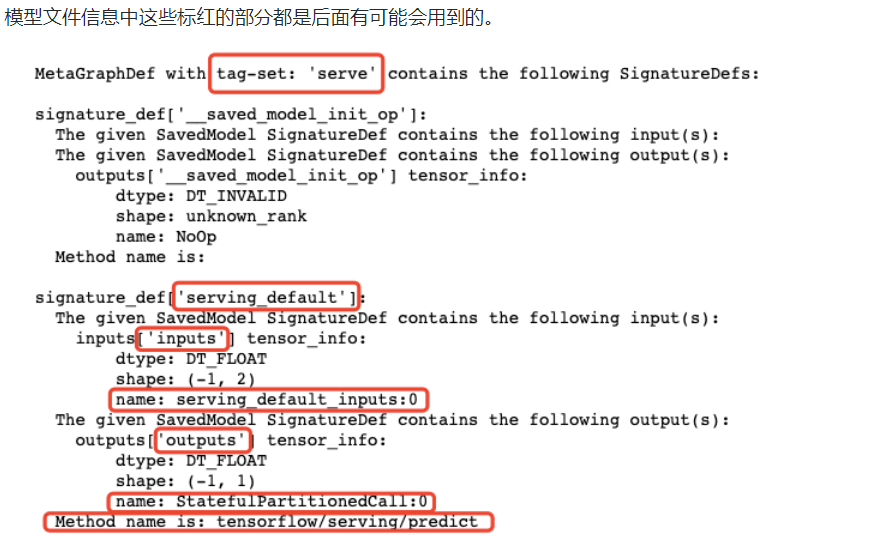

In [ ]:
#二，创建spark(scala)项目，在项目中添加java版本的tensorflow对应的jar包依赖
<!-- https://mvnrepository.com/artifact/org.tensorflow/tensorflow -->
<dependency>
    <groupId>org.tensorflow</groupId>
    <artifactId>tensorflow</artifactId>
    <version>1.15.0</version>
</dependency>

也可以从下面网址中直接下载 org.tensorflow.tensorflow的jar包

以及其依赖的org.tensorflow.libtensorflow 和 org.tensorflowlibtensorflow_jni的jar包 放到项目中。

https://mvnrepository.com/artifact/org.tensorflow/tensorflow/1.15.0